In [1]:
import logging
import warnings
from typing import Optional, Any, Literal

import numpy as np
import matplotlib.pyplot as plt

from gwpy.types import Series
from gwpy.frequencyseries import FrequencySeries
import astropy.units as u
import lalsimulation.gwsignal.core.waveform as wfm

from gw_signal_tools.inner_product import inner_product, inner_product_computation, norm
from gw_signal_tools.waveform_utils import restrict_f_range

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.


In [2]:
from gw_signal_tools import PLOT_STYLE_SHEET
plt.style.use(PLOT_STYLE_SHEET)

## Code Tests

In [3]:
isinstance('test', str)

True

In [4]:
x_vals = np.arange(5)

y_vals = 2.0 * np.arange(5)

out = np.polyfit(x_vals, y_vals, 1, full=True)

In [5]:
print(out)

(array([2.00000000e+00, 1.12769851e-15]), array([3.00161574e-30]), 2, array([1.34777468, 0.42837299]), 1.1102230246251565e-15)


In [6]:
test = [1,2,3]

test.pop(0)

test

[2, 3]

In [7]:
test = np.arange(5)
test[np.logical_not(5 * [False])] = 96

test

array([96, 96, 96, 96, 96])

In [8]:
test[np.logical_not(5 * [True])]

array([], dtype=int64)

In [9]:
np.nanargmin([0.0, np.nan, 1.0, -1.0])

3

In [10]:
# test = np.zeros((2,2))
# # test = u.Quantity(np.zeros((2,2)))

# test[0, 1] = 2.0 * u.s

# test

Hmmm, error, that's awkward... Then we have to find workaround for Fisher matrix to hold values with different values

## Testing Implementation

In [11]:
from gw_signal_tools.fisher_utils import fisher_val_v3

In [12]:
# f_min = 10.*u.Hz  # Cutoff frequency
f_min = 20.*u.Hz  # Cutoff frequency
f_max = 1024. * u.Hz  # Cutoff from PSD
# delta_f = 2**-6 * u.Hz  # Actually works much better
delta_f = 2**-8 * u.Hz  # Actually works much better
delta_t = 1.0/4096.0 * u.s
f_ref = 20.*u.Hz  # Frequency where we specify spins
# f_ref = f_min  # Frequency where we specify spins
distance = 1.*u.Mpc
inclination = 0.0*u.rad  # Value taken from posteriors.ipynb, where posterior of inclination is plotted
phiRef = 0.*u.rad
eccentricity = 0.*u.dimensionless_unscaled
longAscNodes = 0.*u.rad
meanPerAno = 0.*u.rad


# Define the approximant
approximant = 'IMRPhenomXPHM'
# approximant = 'SEOBNRv4'

# Initialize the generator
gen = wfm.LALCompactBinaryCoalescenceGenerator(approximant)

wf_center_parameters = {
    'total_mass': 100.*u.solMass,
    # 'mass_ratio': 0.5*u.dimensionless_unscaled,
    'sym_mass_ratio': 0.05*u.dimensionless_unscaled,
    'f22_start' : f_min,
    'f_max' : f_max,
    'deltaT' : delta_t,
    'deltaF' : delta_f,
    'f22_ref': f_ref,
    'phi_ref' : phiRef,
    'distance' : distance,
    'inclination' : inclination,
    'eccentricity' : eccentricity,
    'longAscNodes' : longAscNodes,
    'meanPerAno' : meanPerAno,
    'condition' : 0
    # 'condition' : 1  # Needs to be on for SEOB
}

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


### Convergence Testing

In [13]:
more_step_sizes = np.reshape(np.outer([1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8], [5, 1]), -1)

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/lalsimulation/gwsignal/core/utils.py:277: UserWarning: The larger object cannot be determined, assuming m1 >= m2.
  warnings.warn(warn_string)
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWavefo

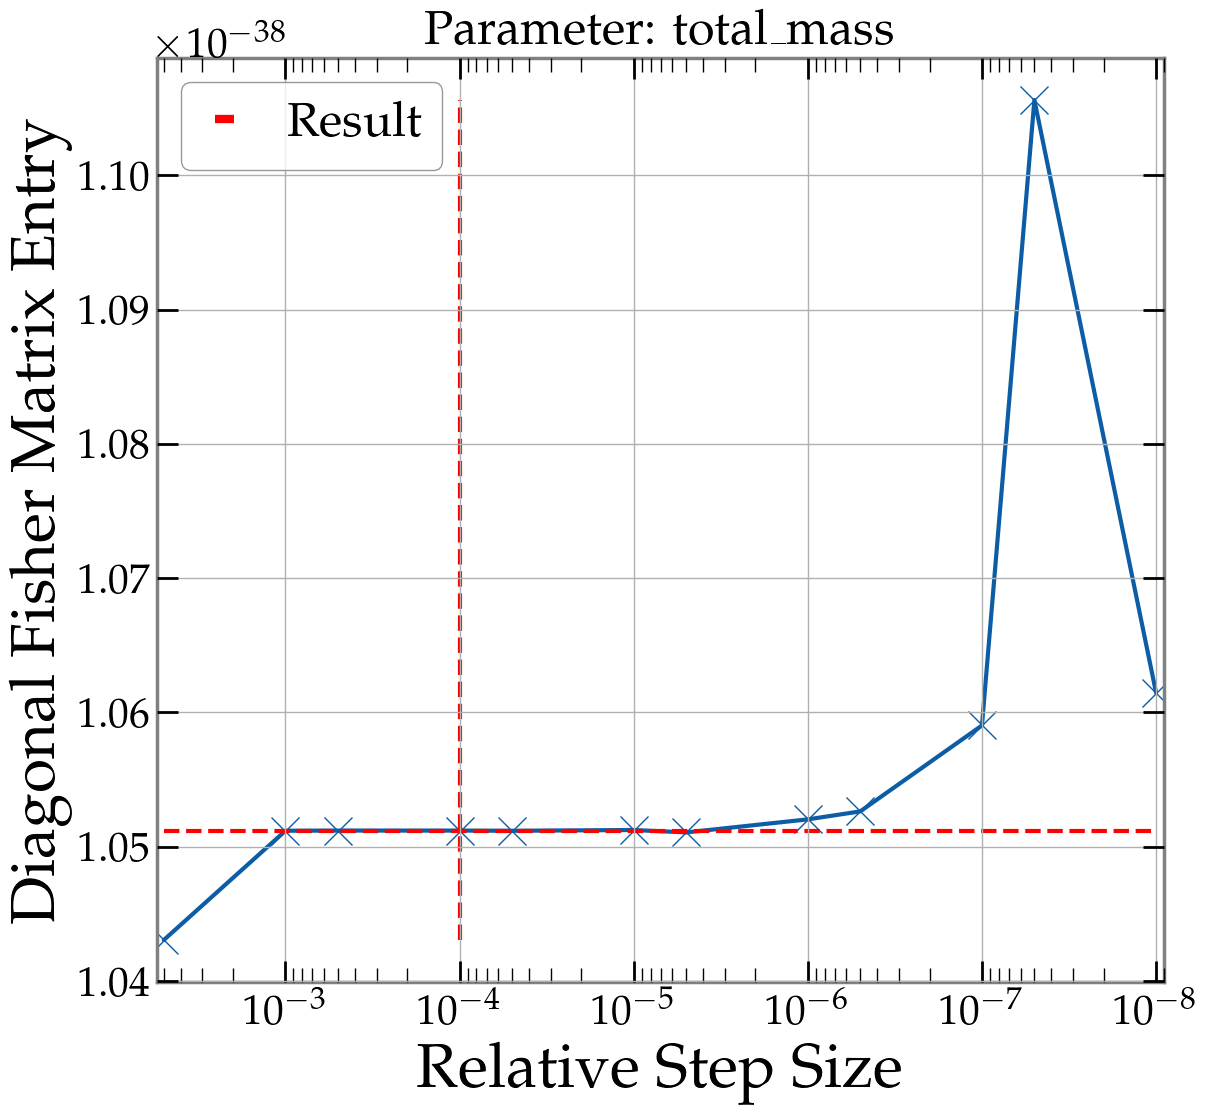

In [14]:
fisher_test_rel_crit = fisher_val_v3(
    wf_center_parameters,
    'total_mass',
    gen,
    step_sizes=more_step_sizes,
    convergence_plot=True
)


# fisher_test_rel_crit_2 = fisher_val_v3(
#     wf_center_parameters,
#     'total_mass',
#     gen,
#     step_sizes=more_step_sizes,
#     convergence_threshold=0.0,  # Cannot be reached, want to see convergence
#     convergence_plot=True
# )

# We see convergence anyway for 'stem' check

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code 

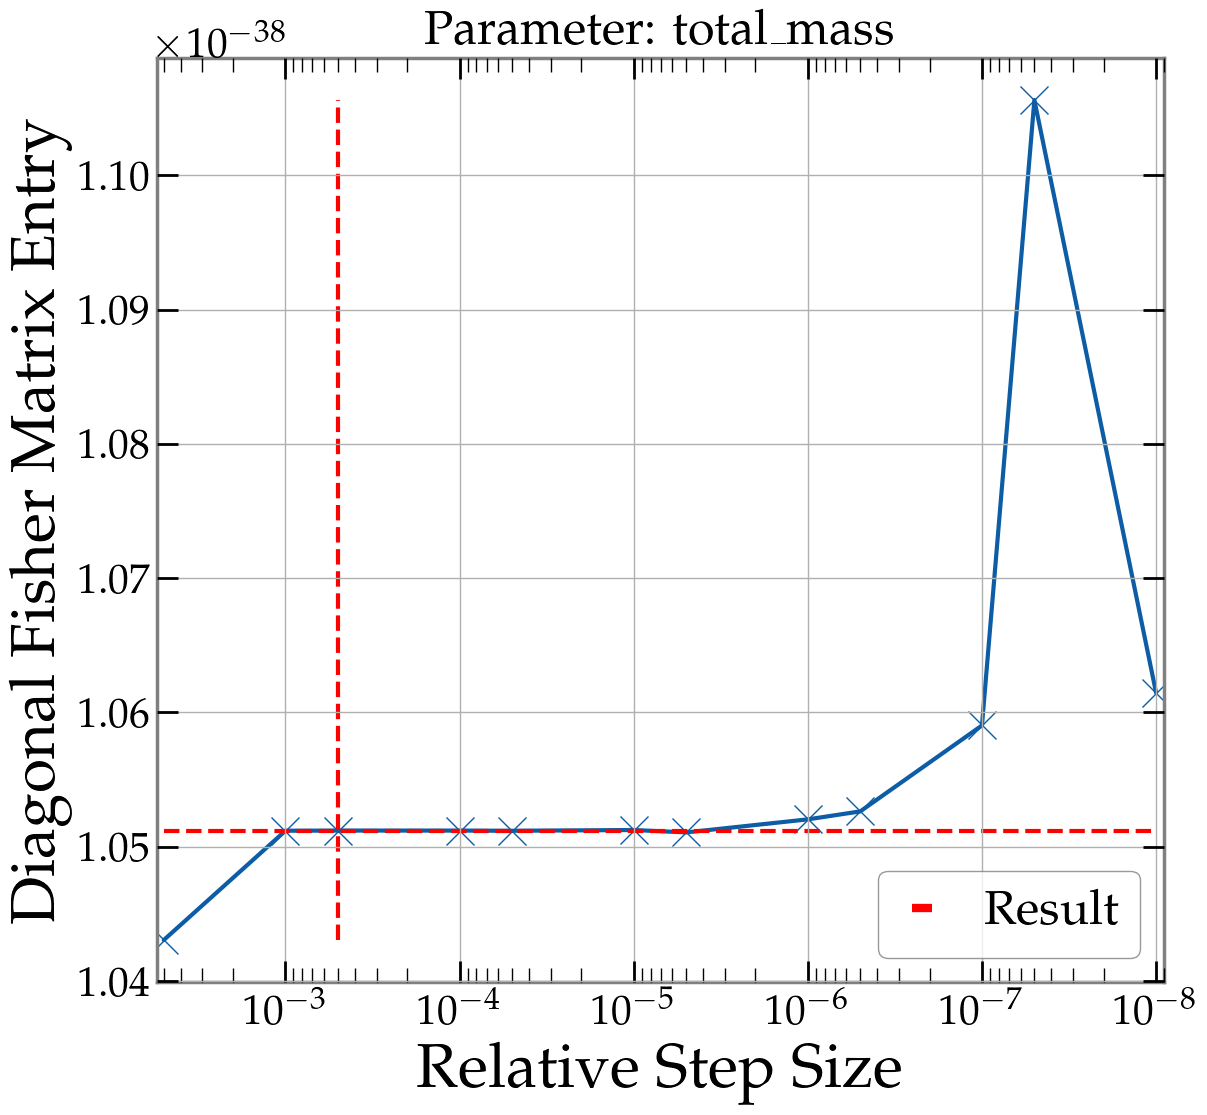

In [15]:
fisher_test_diff_crit = fisher_val_v3(
    wf_center_parameters,
    'total_mass',
    gen,
    step_sizes=more_step_sizes,
    convergence_check='diff_norm',
    convergence_plot=True
)


# fisher_test_diff_crit_2 = fisher_val_v3(
#     wf_center_parameters,
#     'total_mass',
#     gen,
#     step_sizes=more_step_sizes,
#     convergence_check='diff_norm',
#     convergence_threshold=0.0,  # Cannot be reached, want to see convergence
#     convergence_plot=True
# )

# We see convergence anyway for 'stem' check

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code 

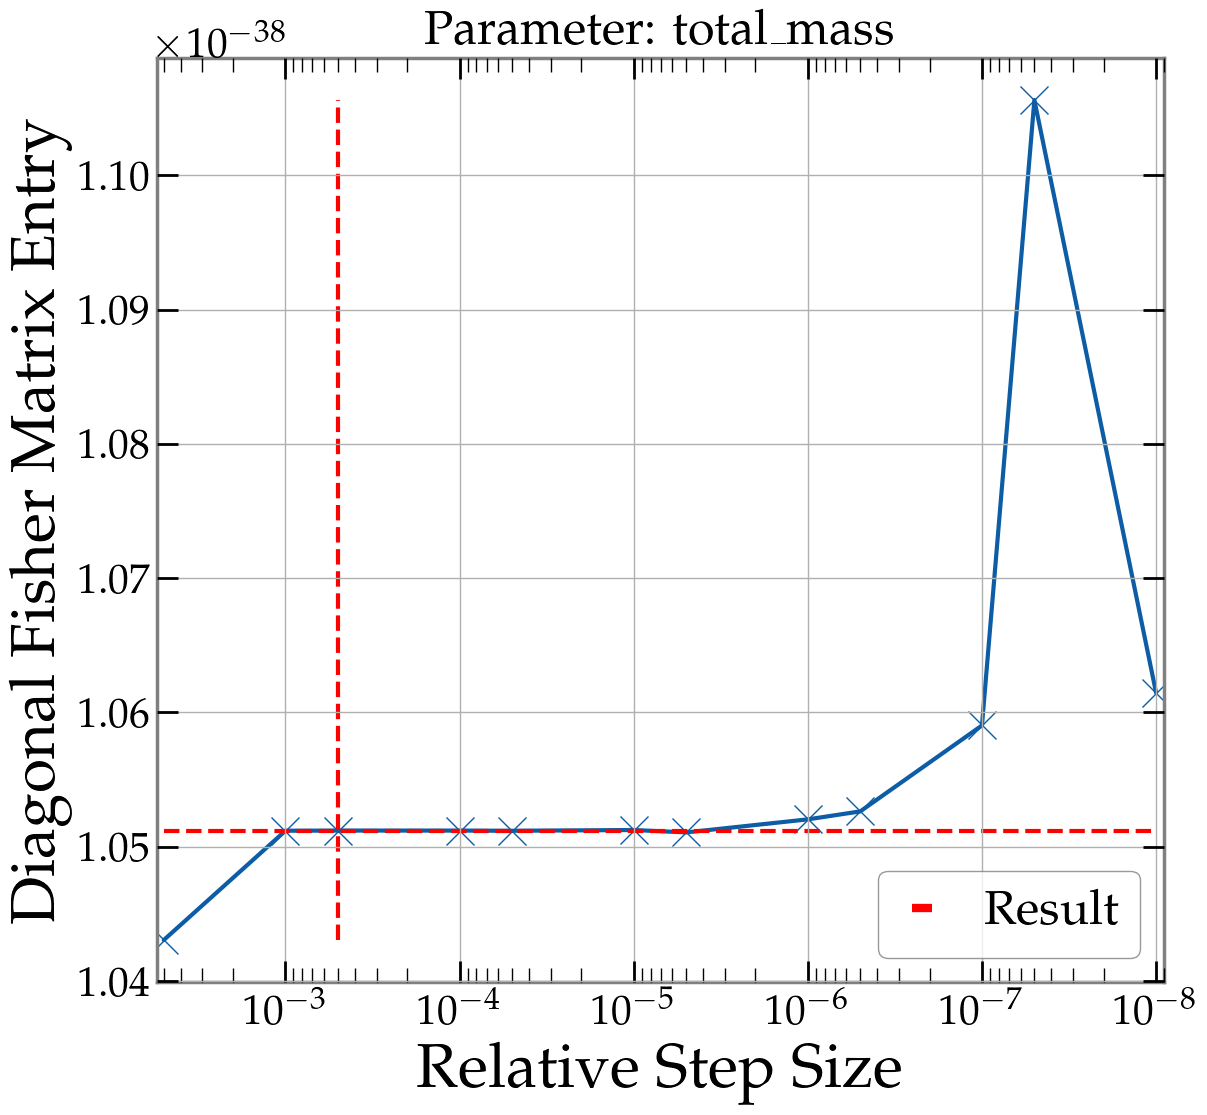

In [16]:
fisher_test_overlap_crit = fisher_val_v3(
    wf_center_parameters,
    'total_mass',
    gen,
    step_sizes=more_step_sizes,
    convergence_check='mismatch',
    convergence_plot=True
)


# fisher_test_overlap_crit_2 = fisher_val_v3(
#     wf_center_parameters,
#     'total_mass',
#     gen,
#     step_sizes=more_step_sizes,
#     convergence_check='mismatch',
#     convergence_threshold=0.0,  # Cannot be reached, want to see convergence
#     convergence_plot=True
# )

# We see convergence anyway for 'stem' check

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code 

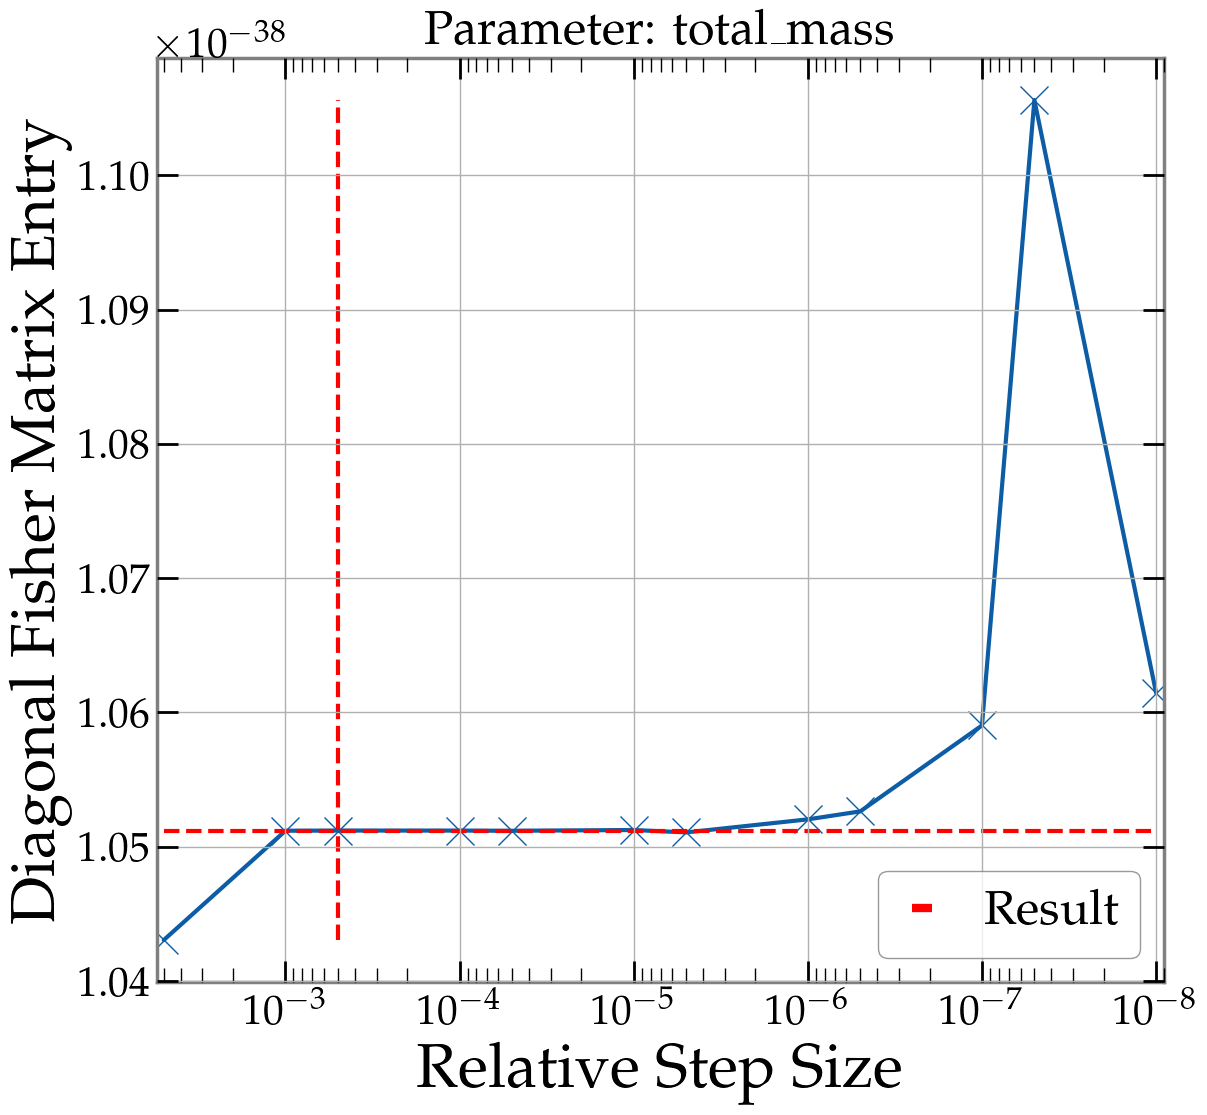

In [17]:
fisher_test_stem_crit = fisher_val_v3(
    wf_center_parameters,
    'total_mass',
    gen,
    step_sizes=more_step_sizes,
    convergence_check='stem',
    convergence_plot=True
)


# fisher_test_stem_crit_2 = fisher_val_v3(
#     wf_center_parameters,
#     'total_mass',
#     gen,
#     step_sizes=more_step_sizes,
#     convergence_check='stem',
#     convergence_threshold=0.0,  # Cannot be reached, want to see convergence
#     convergence_plot=True
# )

# We see convergence anyway for 'stem' check

Comparison of Estimates

In [18]:
print(fisher_test_rel_crit, fisher_test_diff_crit, fisher_test_overlap_crit, fisher_test_stem_crit)

[[1.05120682e-38]] [[1.05120851e-38]] [[1.05120851e-38]] [[1.05120851e-38]]


Very good

### Testing Different Parameters

In [19]:
# f_min = 10.*u.Hz  # Cutoff frequency
f_min = 20.*u.Hz  # Cutoff frequency
f_max = 1024. * u.Hz  # Cutoff from PSD
# delta_f = 2**-6 * u.Hz  # Actually works much better
delta_f = 2**-8 * u.Hz  # Actually works much better
delta_t = 1.0/4096.0 * u.s
f_ref = 20.*u.Hz  # Frequency where we specify spins
# f_ref = f_min  # Frequency where we specify spins
distance = 1.*u.Mpc
inclination = 0.0*u.rad  # Value taken from posteriors.ipynb, where posterior of inclination is plotted
phiRef = 0.*u.rad
eccentricity = 0.*u.dimensionless_unscaled
longAscNodes = 0.*u.rad
meanPerAno = 0.*u.rad


# Define the approximant
approximant = 'IMRPhenomXPHM'
# approximant = 'SEOBNRv4'

# Initialize the generator
gen = wfm.LALCompactBinaryCoalescenceGenerator(approximant)

sym_mass_ratio_check_params = {
    'total_mass': 42.*u.solMass,
    'sym_mass_ratio': 0.05*u.dimensionless_unscaled,
    'f22_start' : f_min,
    'f_max' : f_max,
    'deltaT' : delta_t,
    'deltaF' : delta_f,
    'f22_ref': f_ref,
    'phi_ref' : phiRef,
    'distance' : distance,
    'inclination' : inclination,
    'eccentricity' : eccentricity,
    'longAscNodes' : longAscNodes,
    'meanPerAno' : meanPerAno,
    'condition' : 0
    # 'condition' : 1  # Needs to be on for SEOB
}

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code 

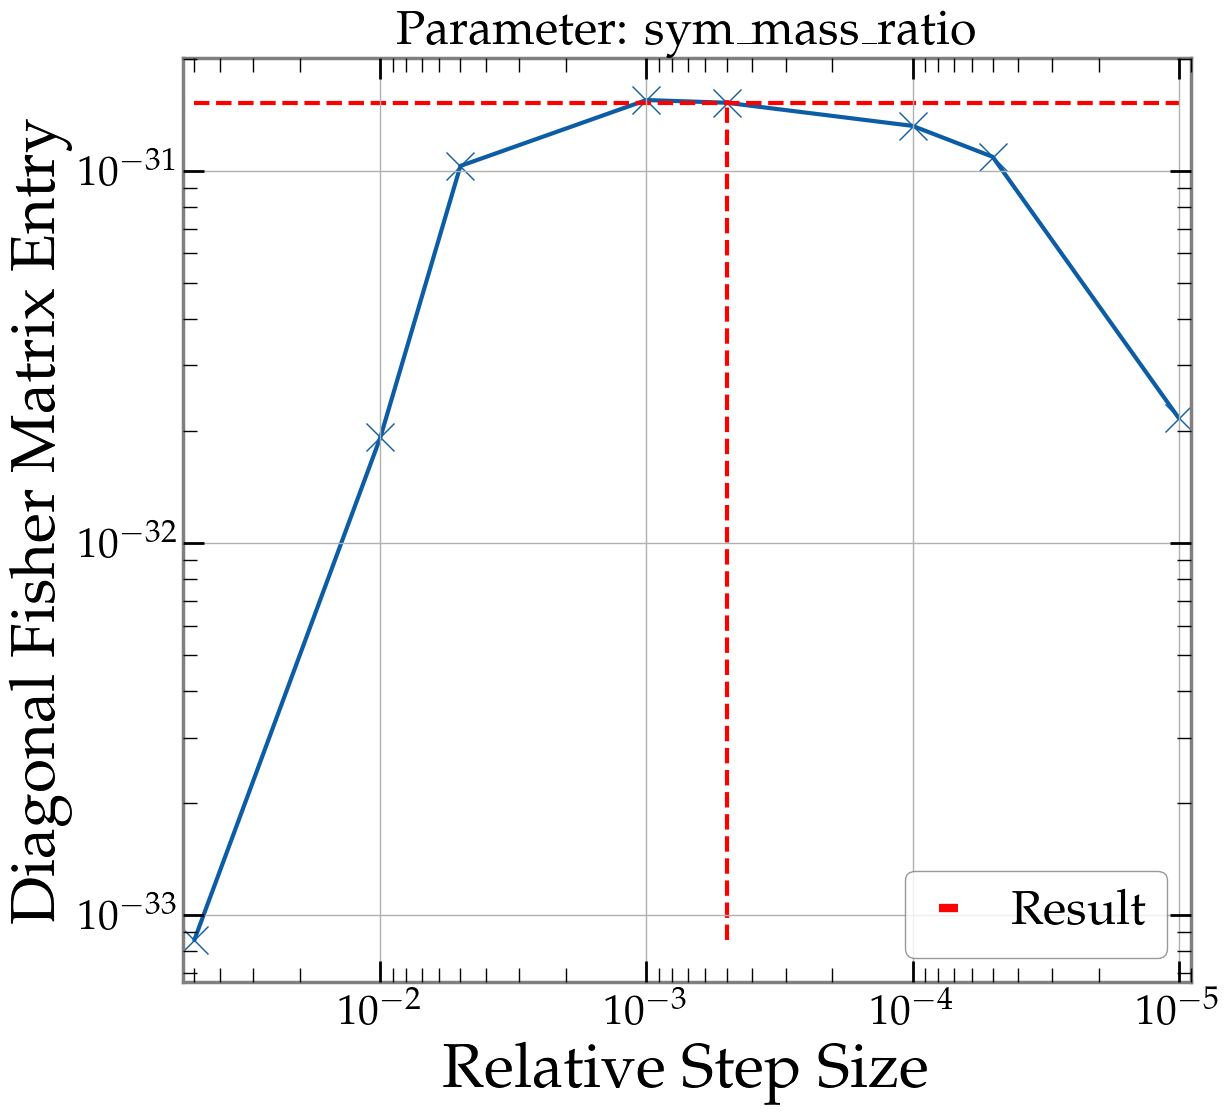

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code 

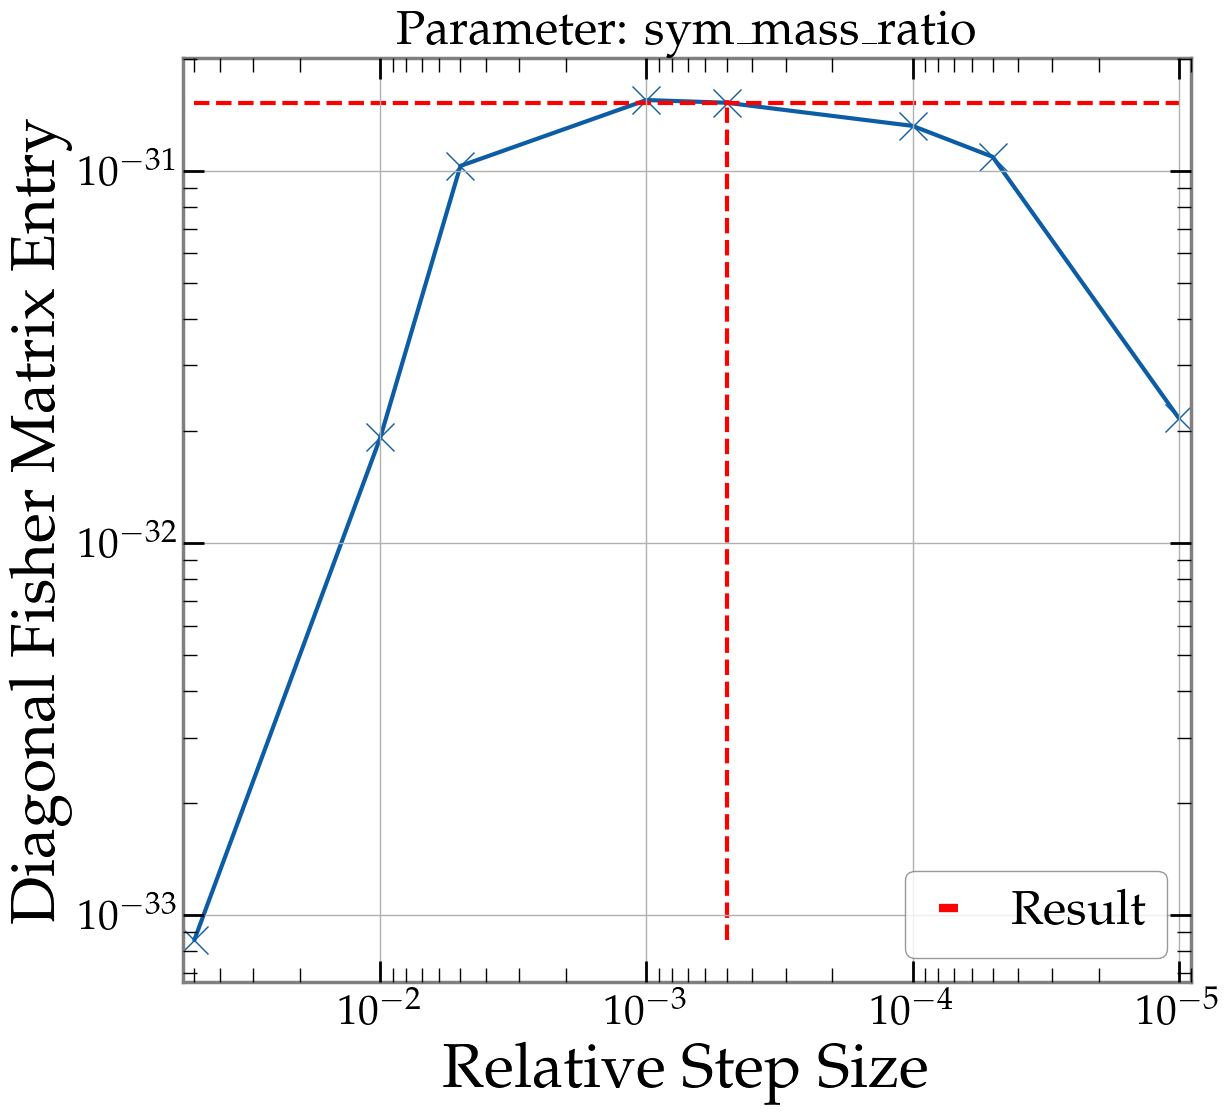

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code 

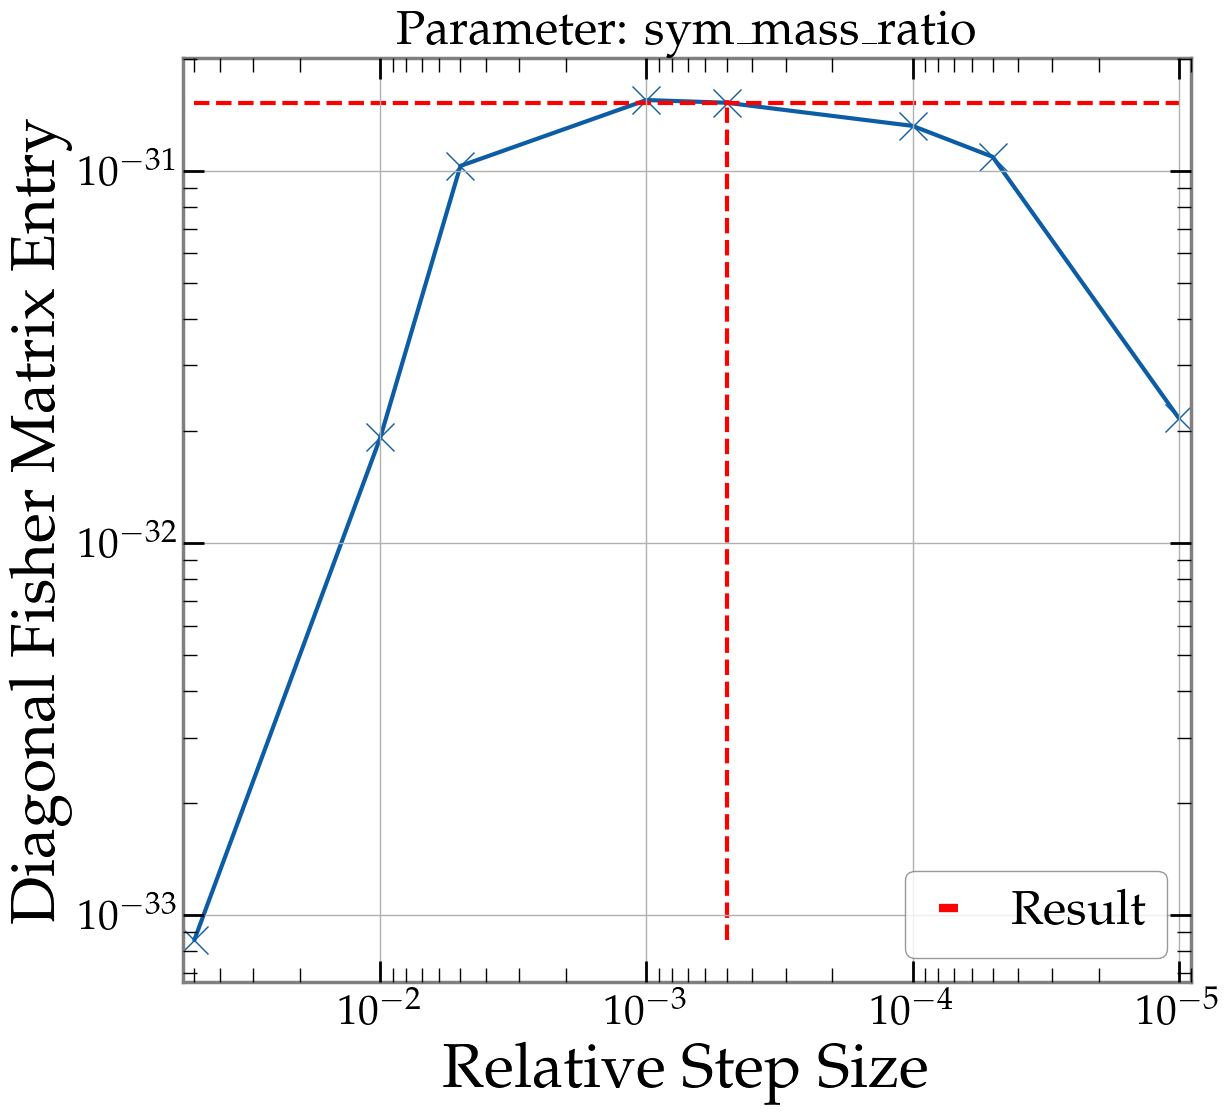

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code 

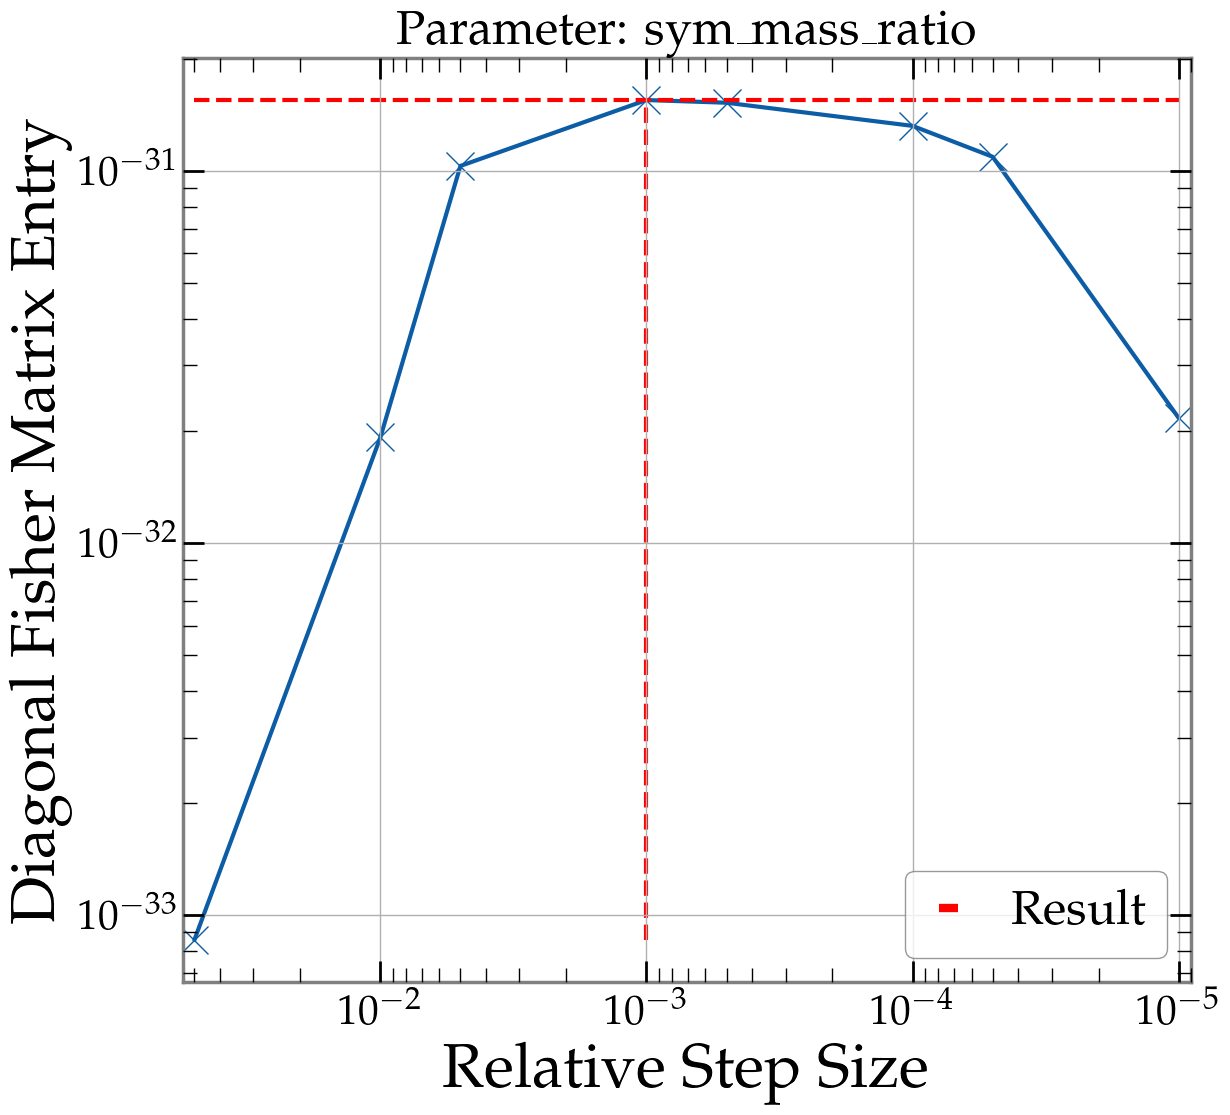

In [20]:
fisher_vals_sym_mass_ratio = []

for check in ['rel_deviation', 'diff_norm', 'mismatch', 'stem']:
    fisher_test_val = fisher_val_v3(
        sym_mass_ratio_check_params,
        'sym_mass_ratio',
        gen,
        convergence_check=check,
        # convergence_threshold=0.0,
        convergence_plot=True
    )

    fisher_vals_sym_mass_ratio += [fisher_test_val]

In [21]:
print(fisher_vals_sym_mass_ratio)

[array([[1.52506289e-31]]), array([[1.52506289e-31]]), array([[1.52506289e-31]]), array([[1.55072987e-31]])]


Looks like 1e-6 is already too small...

In [22]:
# f_min = 10.*u.Hz  # Cutoff frequency
f_min = 20.*u.Hz  # Cutoff frequency
f_max = 1024. * u.Hz  # Cutoff from PSD
# delta_f = 2**-6 * u.Hz  # Actually works much better
delta_f = 2**-8 * u.Hz  # Actually works much better
delta_t = 1.0/4096.0 * u.s
f_ref = 20.*u.Hz  # Frequency where we specify spins
# f_ref = f_min  # Frequency where we specify spins
distance = 1.*u.Mpc
inclination = 0.0*u.rad  # Value taken from posteriors.ipynb, where posterior of inclination is plotted
phiRef = 0.*u.rad
eccentricity = 0.*u.dimensionless_unscaled
longAscNodes = 0.*u.rad
meanPerAno = 0.*u.rad


# Define the approximant
approximant = 'IMRPhenomXPHM'
# approximant = 'SEOBNRv4'

# Initialize the generator
gen = wfm.LALCompactBinaryCoalescenceGenerator(approximant)

mass_ratio_check_params = {
    'total_mass': 42.*u.solMass,
    'mass_ratio': 0.5*u.dimensionless_unscaled,
    'f22_start' : f_min,
    'f_max' : f_max,
    'deltaT' : delta_t,
    'deltaF' : delta_f,
    'f22_ref': f_ref,
    'phi_ref' : phiRef,
    'distance' : distance,
    'inclination' : inclination,
    'eccentricity' : eccentricity,
    'longAscNodes' : longAscNodes,
    'meanPerAno' : meanPerAno,
    'condition' : 0
    # 'condition' : 1  # Needs to be on for SEOB
}

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

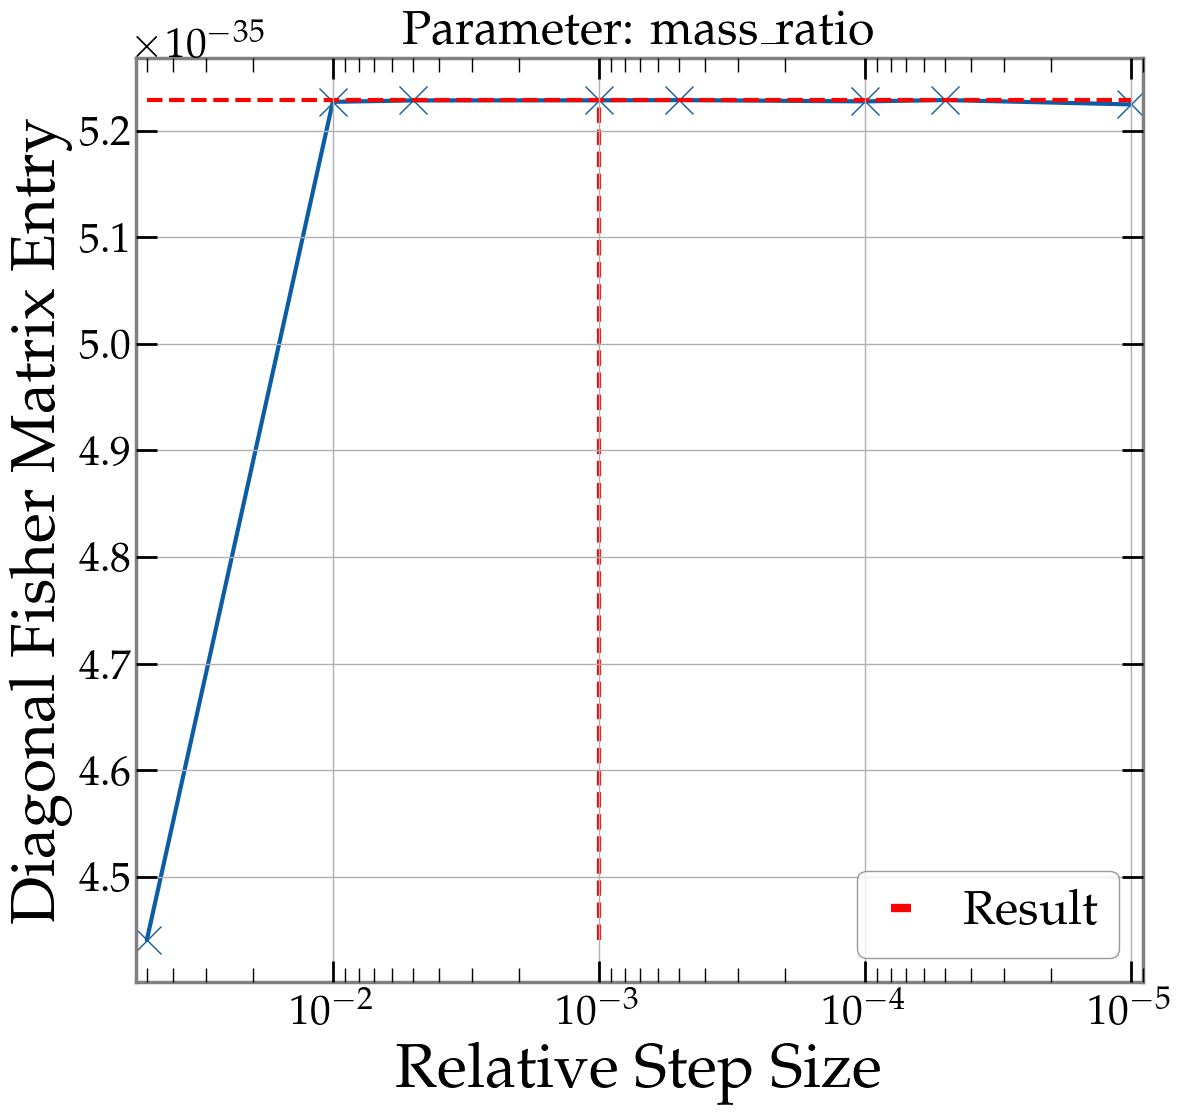

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

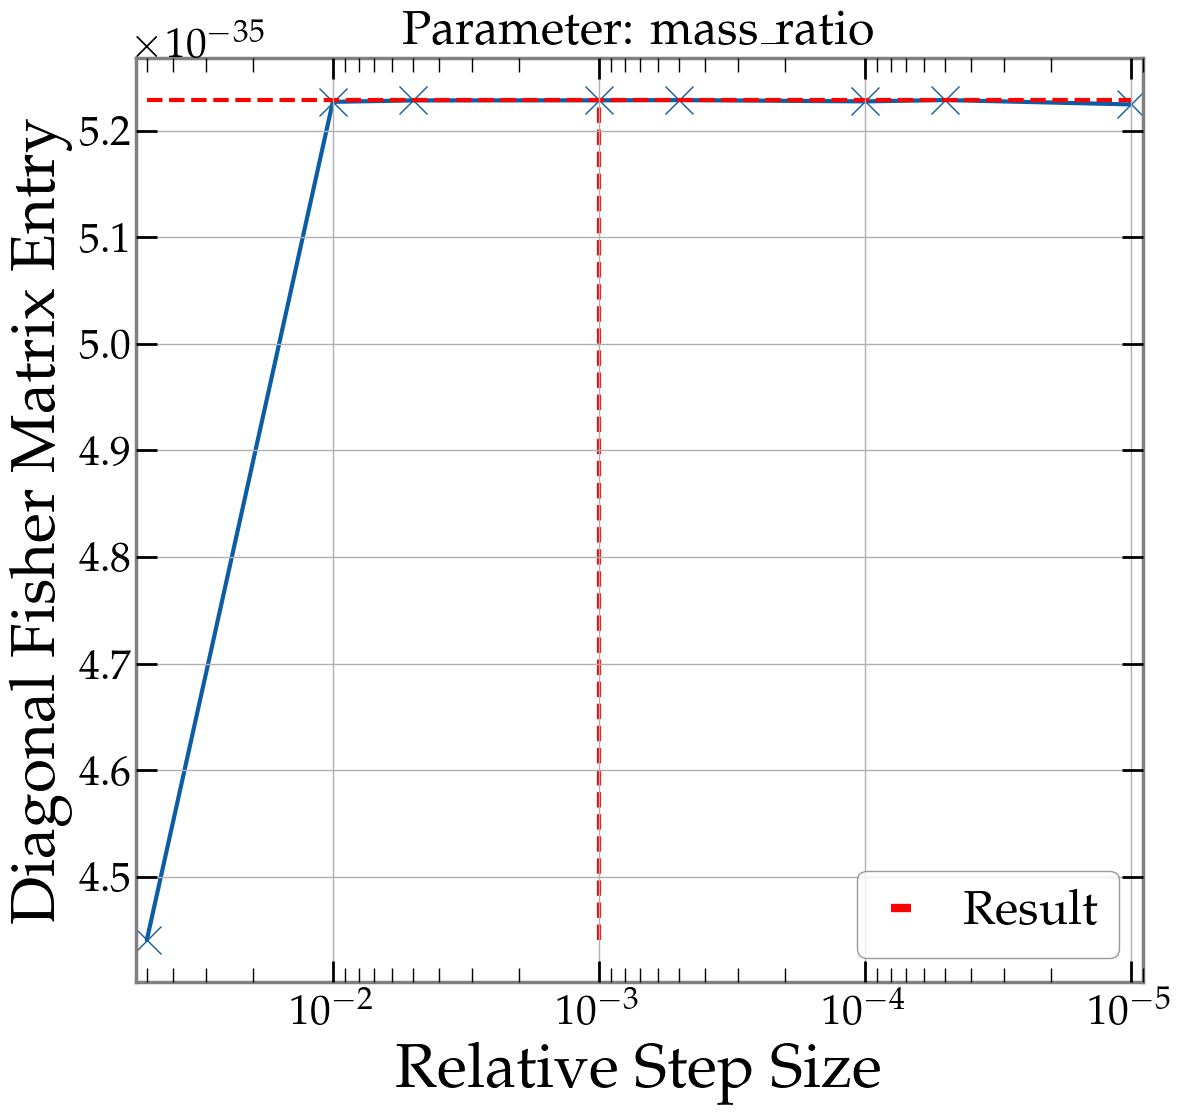

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

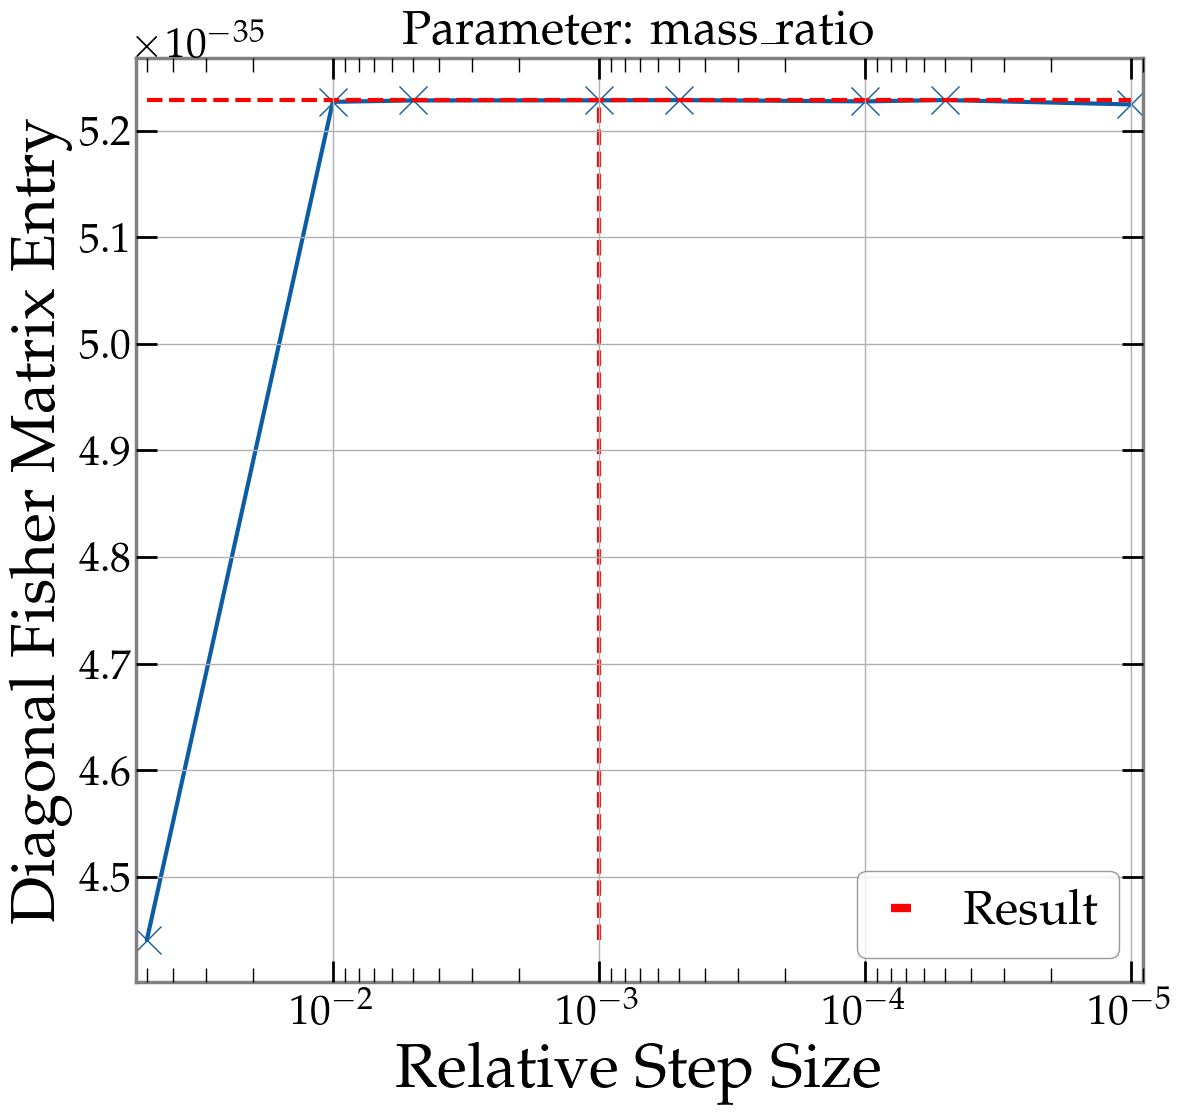

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

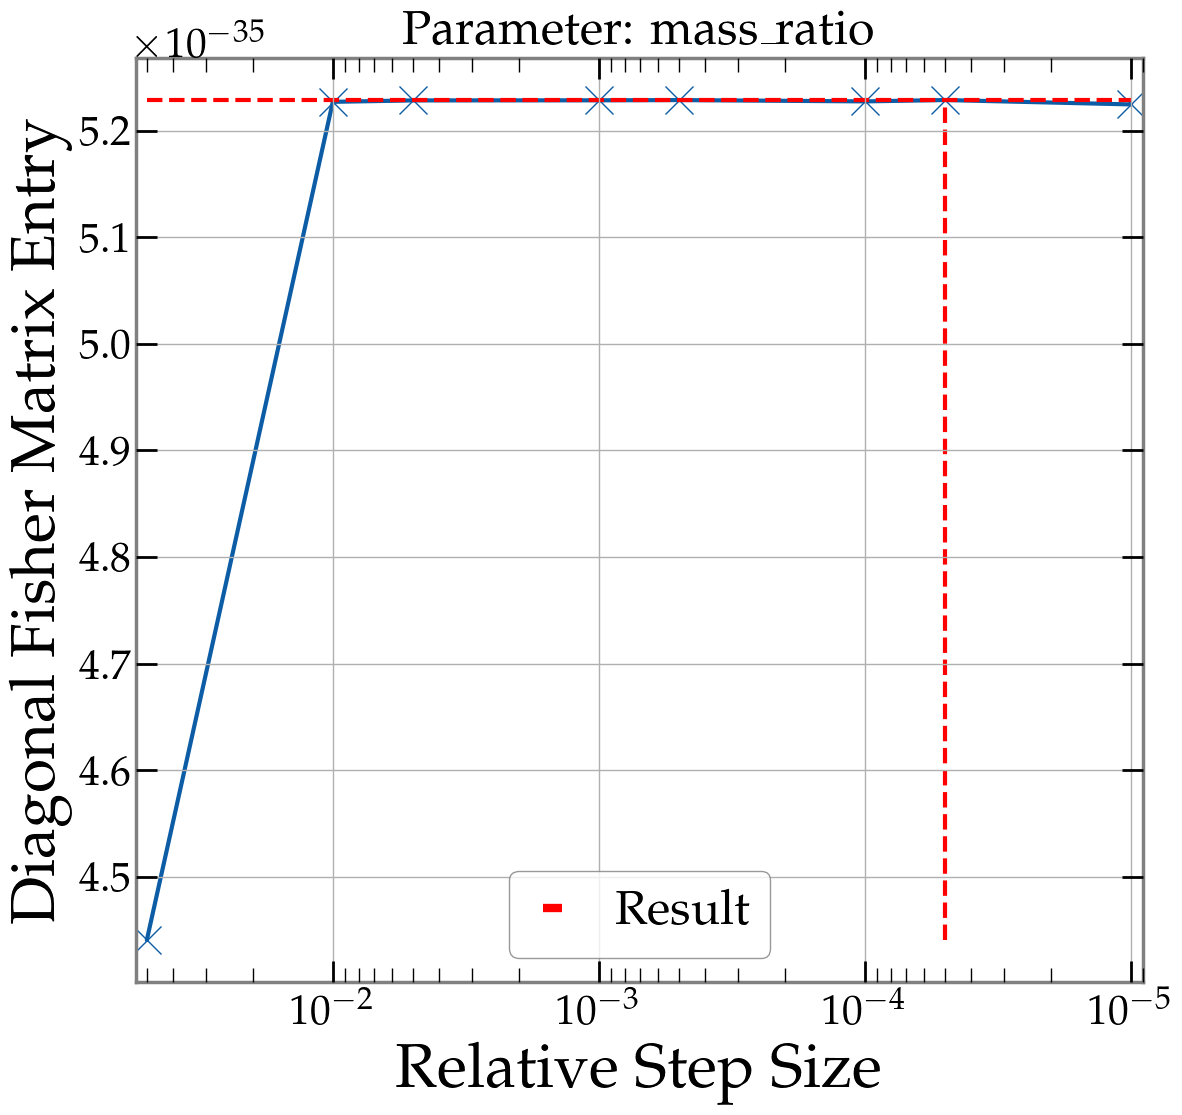

In [23]:
fisher_vals_mass_ratio = []

for check in ['rel_deviation', 'diff_norm', 'mismatch', 'stem']:
    fisher_test_val = fisher_val_v3(
        mass_ratio_check_params,
        'mass_ratio',
        gen,
        convergence_check=check,
        # convergence_threshold=0.0,
        convergence_plot=True
    )

    fisher_vals_mass_ratio += [fisher_test_val]

In [24]:
print(fisher_vals_mass_ratio)

[array([[5.22868191e-35]]), array([[5.22868191e-35]]), array([[5.22868191e-35]]), array([[5.22894704e-35]])]


In [25]:
# f_min = 10.*u.Hz  # Cutoff frequency
f_min = 20.*u.Hz  # Cutoff frequency
f_max = 1024. * u.Hz  # Cutoff from PSD
# delta_f = 2**-6 * u.Hz  # Actually works much better
delta_f = 2**-8 * u.Hz  # Actually works much better
delta_t = 1.0/4096.0 * u.s
f_ref = 20.*u.Hz  # Frequency where we specify spins
# f_ref = f_min  # Frequency where we specify spins
distance = 1.*u.Mpc
inclination = 0.0*u.rad  # Value taken from posteriors.ipynb, where posterior of inclination is plotted
phiRef = 0.*u.rad
eccentricity = 0.*u.dimensionless_unscaled
longAscNodes = 0.*u.rad
meanPerAno = 0.*u.rad


# Define the approximant
approximant = 'IMRPhenomXPHM'
# approximant = 'SEOBNRv4'

# Initialize the generator
gen = wfm.LALCompactBinaryCoalescenceGenerator(approximant)

spin1z_check_params = {
    'total_mass': 42.*u.solMass,
    'mass_ratio': 0.5*u.dimensionless_unscaled,
    'spin1z': 0.2*u.dimensionless_unscaled,
    'f22_start' : f_min,
    'f_max' : f_max,
    'deltaT' : delta_t,
    'deltaF' : delta_f,
    'f22_ref': f_ref,
    'phi_ref' : phiRef,
    'distance' : distance,
    'inclination' : inclination,
    'eccentricity' : eccentricity,
    'longAscNodes' : longAscNodes,
    'meanPerAno' : meanPerAno,
    'condition' : 0
    # 'condition' : 1  # Needs to be on for SEOB
}

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

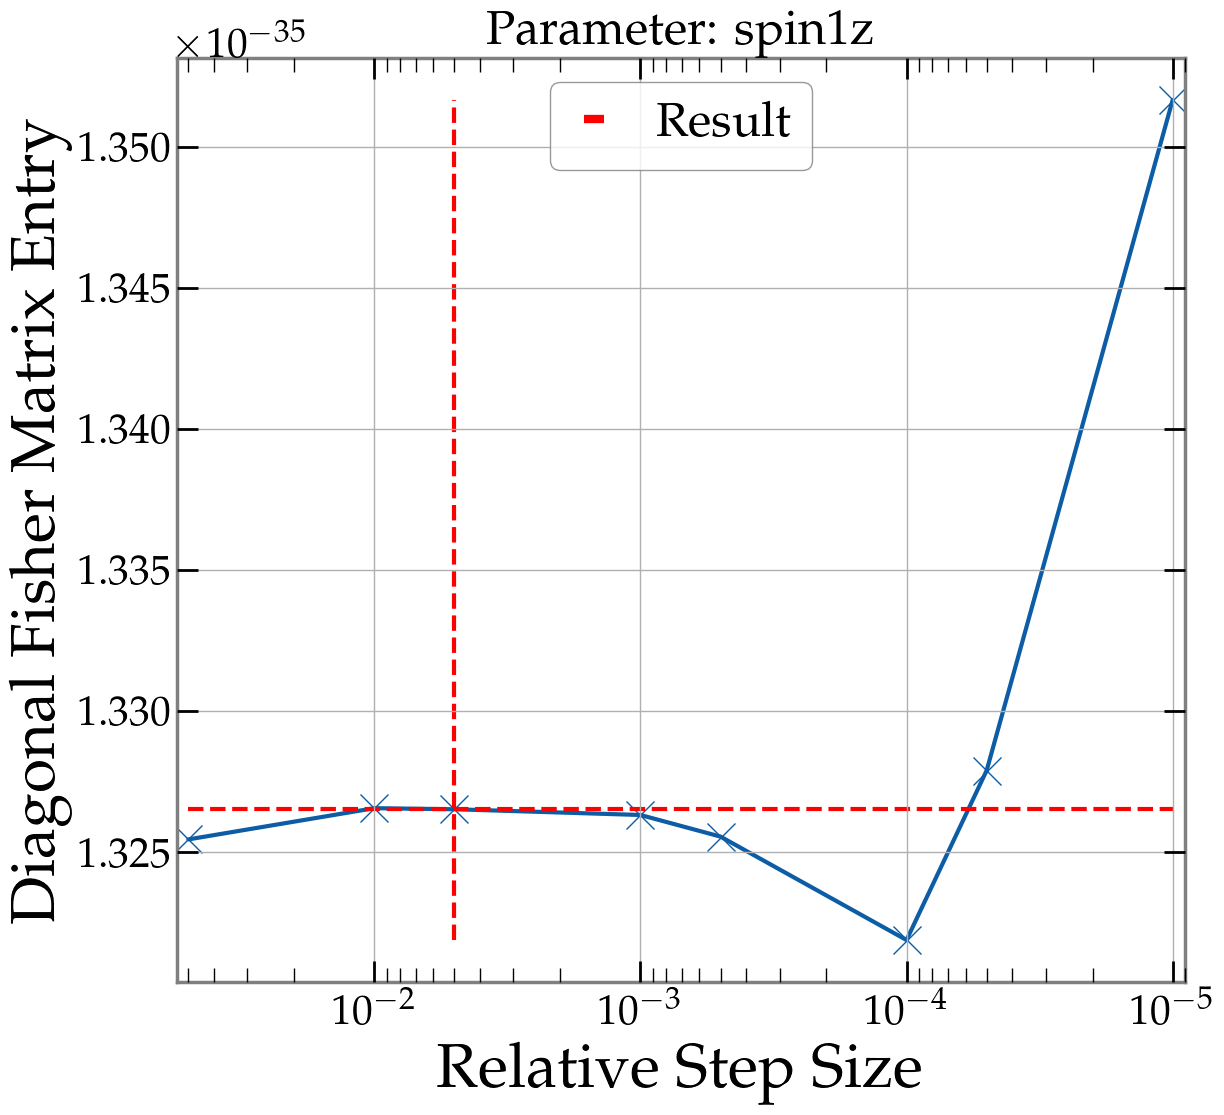

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

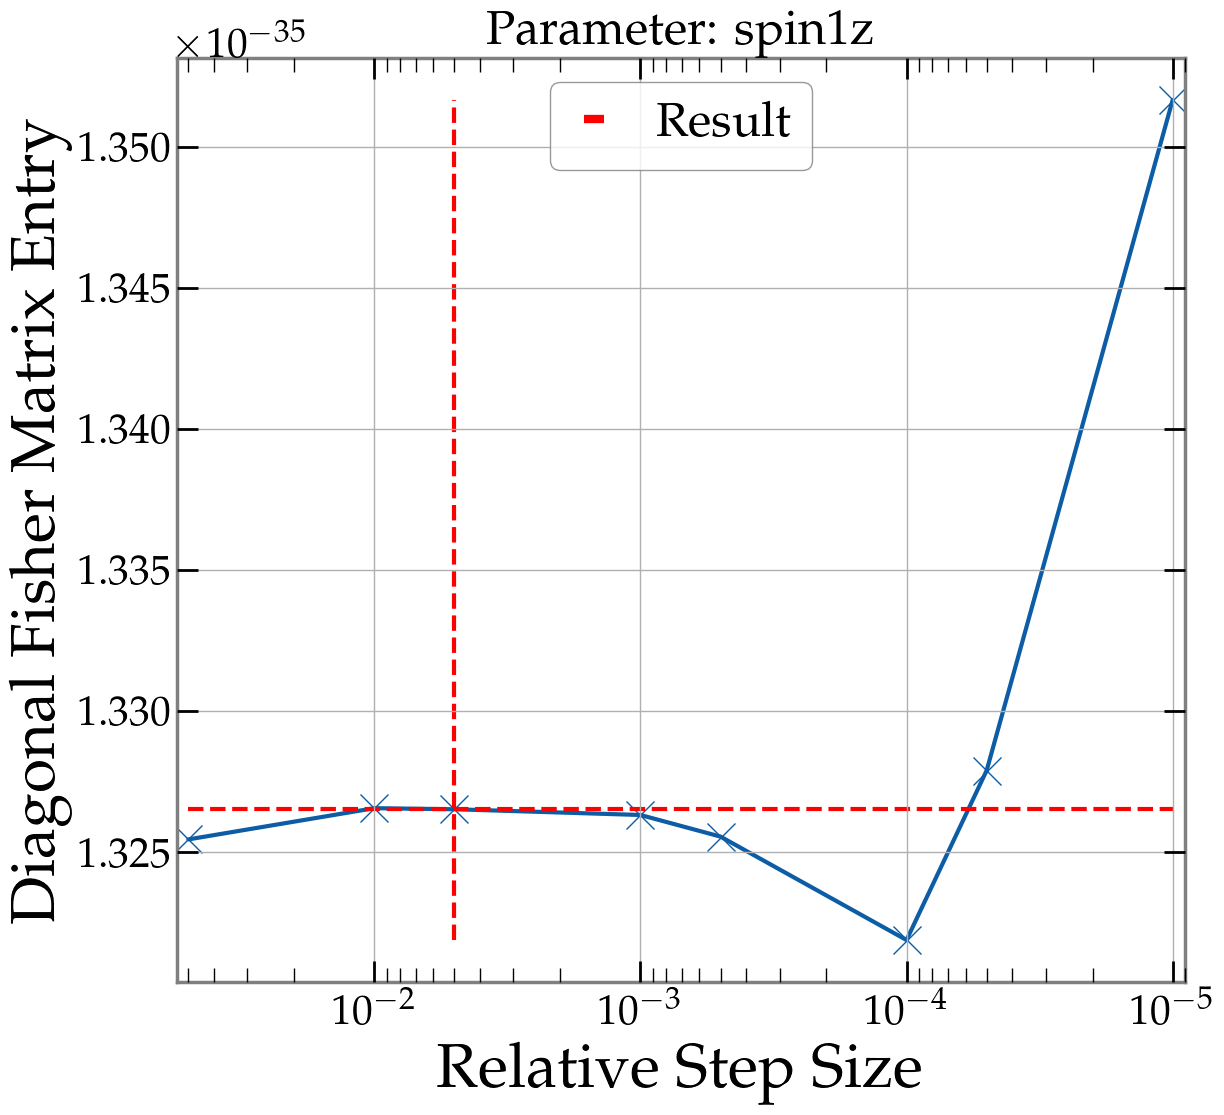

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

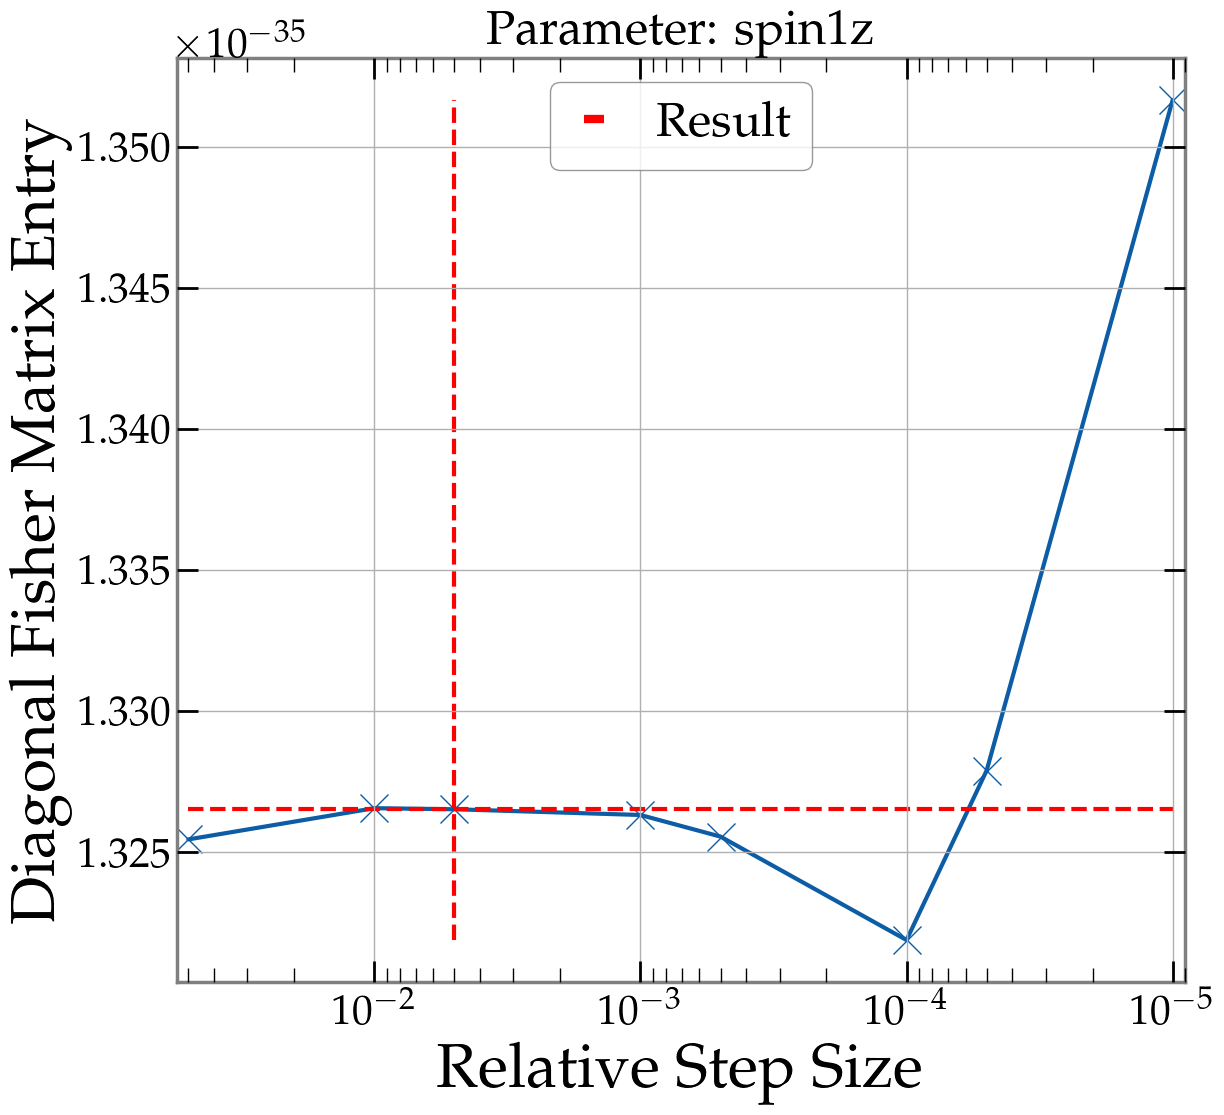

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

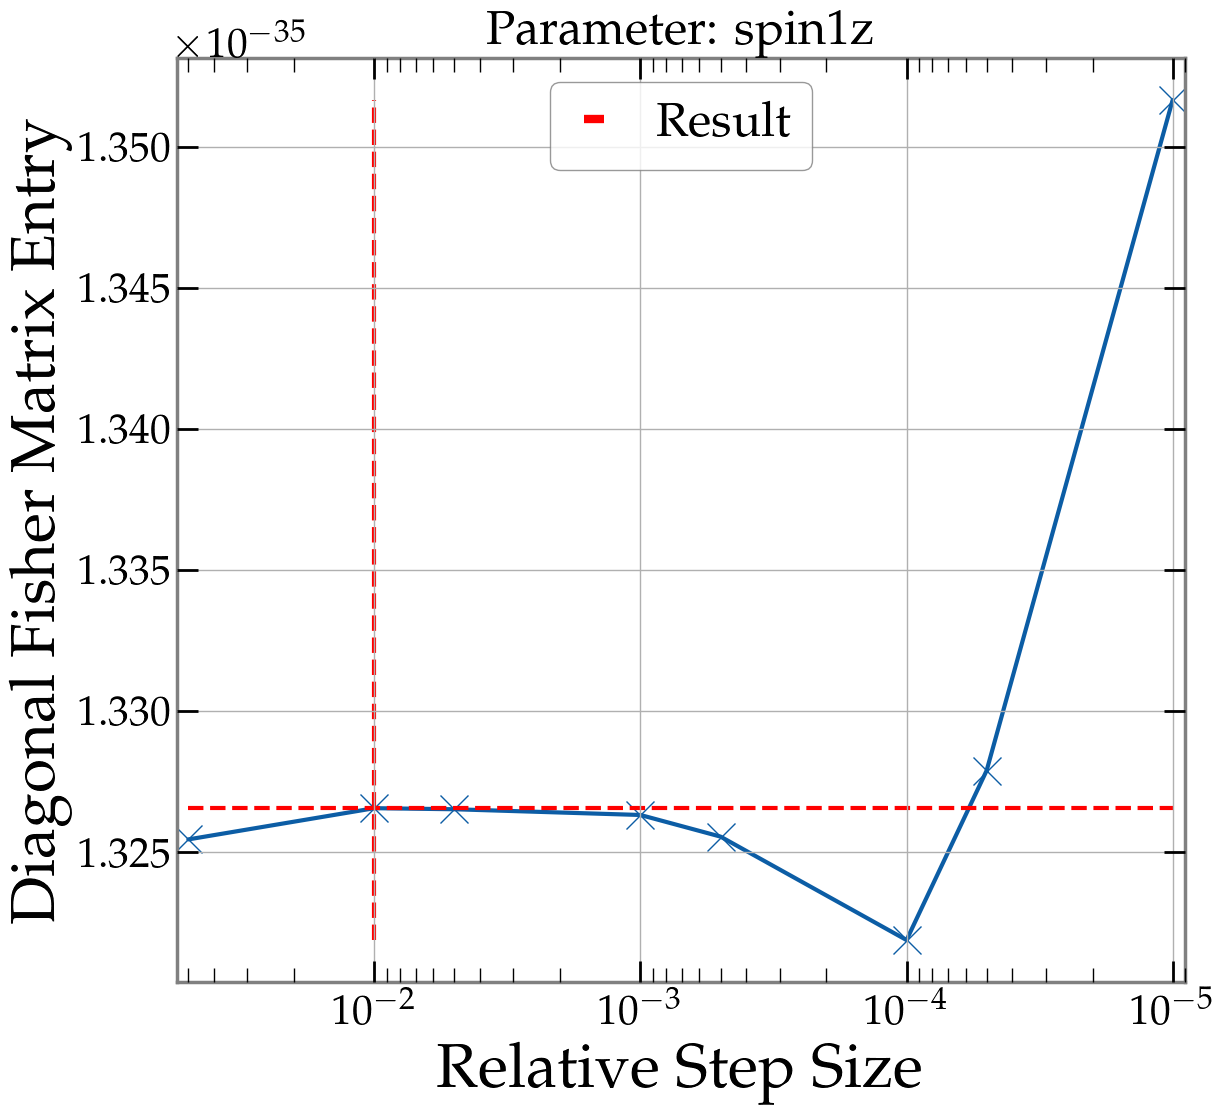

In [26]:
fisher_vals_spin1z = []

for check in ['rel_deviation', 'diff_norm', 'mismatch', 'stem']:
    fisher_test_val = fisher_val_v3(
        spin1z_check_params,
        'spin1z',
        gen,
        convergence_check=check,
        # convergence_threshold=0.0,
        convergence_plot=True
    )

    fisher_vals_spin1z += [fisher_test_val]